In [1]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

In [2]:
dir.create("backup/b1/")

outputRoot=paste0( getwd(), "/backup/b1/")
outputRoot

Warning message in dir.create("backup/b1/"):
“'backup/b1' already exists”


[1] "/data/wangjl/scScripts/backup/b1/"

In [3]:
##
library(Seurat)
library(tidyverse)
library(patchwork)

── Attaching packages ──────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 原理

Monocle进行伪时间分析的核心技术是一种机器学习算法——反向图形嵌入 (Reversed Graph Embedding)。

它分析的前提需要一张展现细胞转录特征相似性关系的图，
- Monocle2使用DDTree降维图，
- Monocle3使用UMAP降维图。

Monocle的机器学习算法可以依据上述降维图形，学习描述细胞如何从一种状态过渡到另一种状态的轨迹。Monocle假设轨迹是树状结构，一端是“根”，另一端是“叶”。一个细胞在生物过程的开始，从根开始沿着主干进行，直到它到达第一个分支。然后，该细胞必须选择一条路径，并沿着树移动越来越远，直到它到达一片叶子。一个细胞的假时间值是它返回根所需的距离。降维方面monocle与seurat的过程大同小异，首先进行数据标准化，其次选择部分基因代表细胞转录特征 ，最后选用适当的算法降维。对Monocle原理感兴趣的同学可以登录官网查看：


http://cole-trapnell-lab.github.io/monocle-release/

# load data

In [23]:
scRNAsub0 <- readRDS("backup/a2/pbmc10k-Tsubset_final.rds")
scRNAsub0

An object of class Seurat 
22860 features across 4641 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

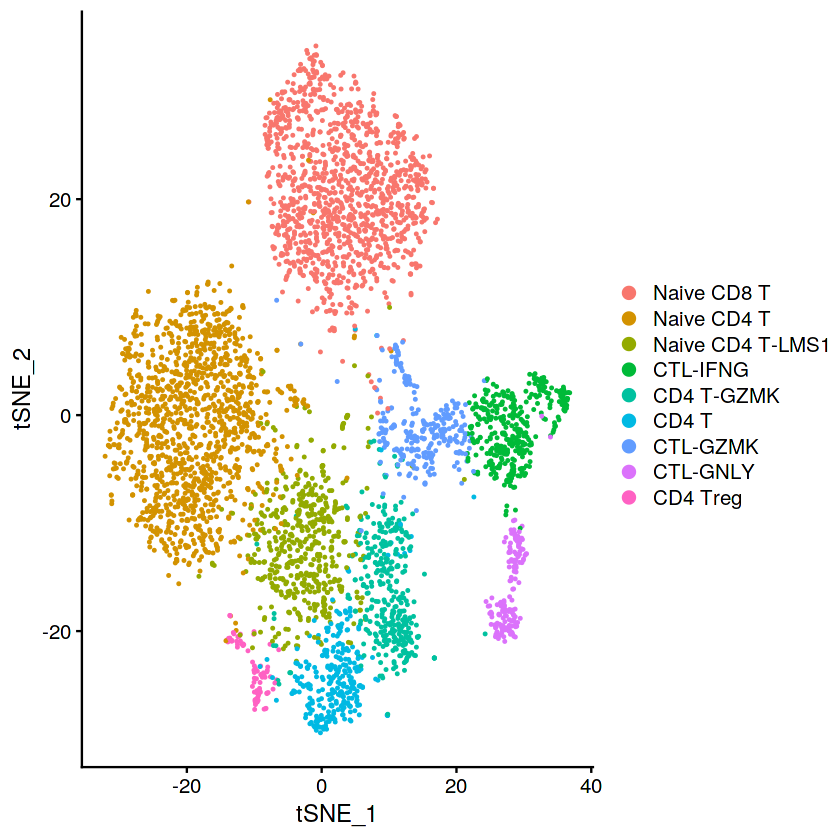

In [24]:
DimPlot(scRNAsub0, reduction = 'tsne')

注意：要导入有发育关系的cluster，否则没有意义。

## 取亚类 CD4

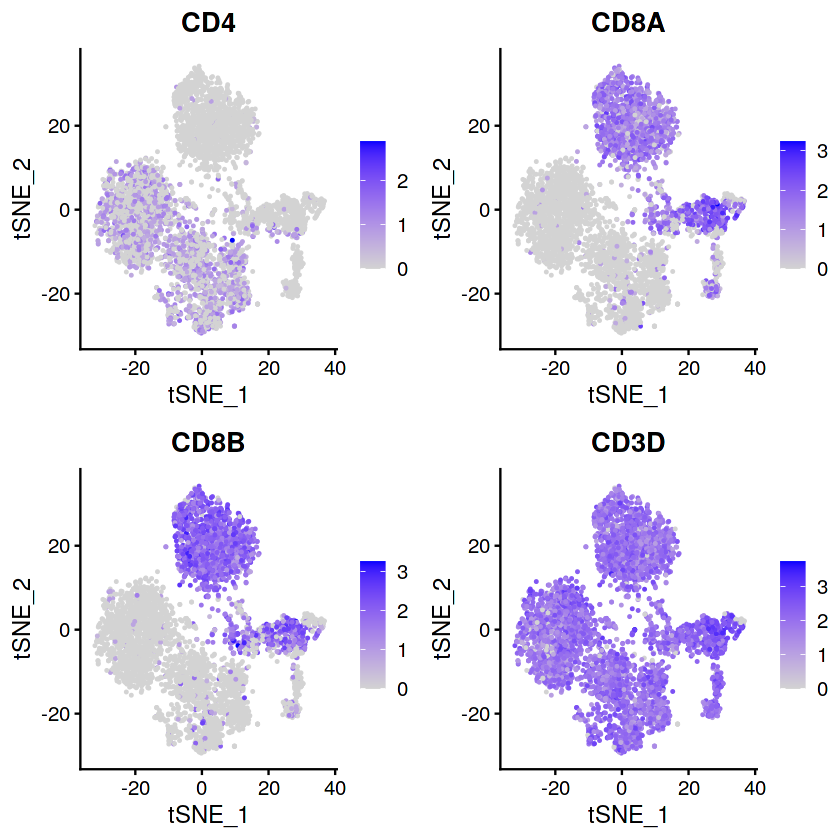

In [25]:
FeaturePlot(scRNAsub0, features = c("CD4","CD8A","CD8B","CD3D"), reduction = "tsne")
# CD4: 1,2  3,5,6,   10

In [26]:
levels(scRNAsub0@active.ident)

[1] "Naive CD8 T"      "Naive CD4 T"      "Naive CD4 T-LMS1" "CTL-IFNG"        
[5] "CD4 T-GZMK"       "CD4 T"            "CTL-GZMK"         "CTL-GNLY"        
[9] "CD4 Treg"

In [27]:
scRNAsub=subset(scRNAsub0, idents = c('Naive CD4 T', 'Naive CD4 T-LMS1', 'CD4 T-GZMK', 'CD4 T', 'CD4 Treg'))
scRNAsub

An object of class Seurat 
22860 features across 2592 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

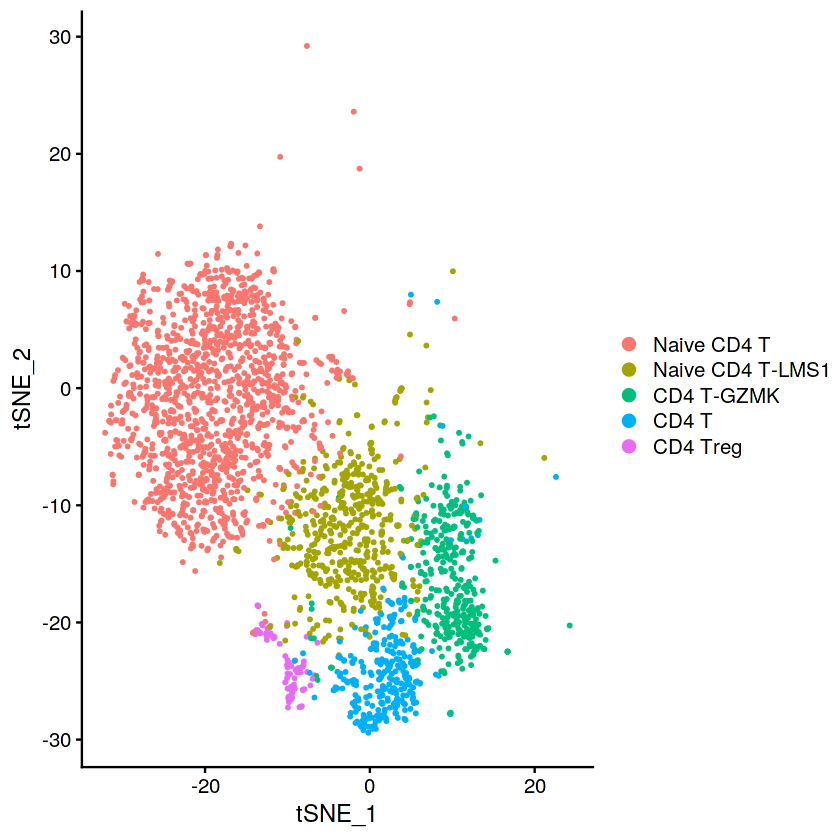

In [28]:
DimPlot(scRNAsub, reduction = 'tsne')

## 导入到monocle

In [6]:
library(monocle)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect,

In [29]:
# DDTree降维图
# Monocle2使用DDTree降维图，Monocle3使用UMAP降维图

#scRNAsub是上一节保存的T细胞子集seurat对象
data1 <- as(as.matrix(scRNAsub@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = scRNAsub@meta.data)

fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)

mycds <- newCellDataSet(data1, #counts矩阵
                        phenoData = pd, # meta.data
                        featureData = fd, #基因名字
                        expressionFamily = negbinomial.size())

expressionFamily参数用于指定表达矩阵的数据类型，有几个选项可以选择：
- 稀疏矩阵用negbinomial.size()，
- FPKM值用tobit()，
- logFPKM值用gaussianff()

In [30]:
mycds
#mycds是Monocle为我们的数据生成的对象，相当于我们在seurat使用的scRNA对象。

CellDataSet (storageMode: environment)
assayData: 22860 features, 2592 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACGAACACCGAATT AAACGAACAGACACCC ... TTTGTTGTCCTAGCTC
    (2592 total)
  varLabels: orig.ident nCount_RNA ... Size_Factor (9 total)
  varMetadata: labelDescription
featureData
  featureNames: AL627309.1 AL627309.3 ... AC007325.4 (22860 total)
  fvarLabels: gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

# 开始

## 预处理

In [31]:
mycds <- estimateSizeFactors(mycds)
mycds <- estimateDispersions(mycds, cores=4, relative_expr = TRUE)
#mycds <- detectGenes(mycds, min_expr = 2)  #很多教程不用

mycds

Removing 299 outliers



CellDataSet (storageMode: environment)
assayData: 22860 features, 2592 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACGAACACCGAATT AAACGAACAGACACCC ... TTTGTTGTCCTAGCTC
    (2592 total)
  varLabels: orig.ident nCount_RNA ... Size_Factor (9 total)
  varMetadata: labelDescription
featureData
  featureNames: AL627309.1 AL627309.3 ... AC007325.4 (22860 total)
  fvarLabels: gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

与seurat把标准化后的表达矩阵保存在对象中不同，monocle只保存一些中间结果在对象中，需要用时再用这些中间结果转化。

经过上面三个函数的计算，mycds对象中多了SizeFactors、Dipersions、num_cells_expressed和num_genes_expressed等信息。

In [32]:
class(mycds)

[1] "CellDataSet"
attr(,"package")
[1] "monocle"

In [33]:
saveRDS(mycds, file = paste0(outputRoot,"mycds-initial.rds") ) #long time: 30s

## 选择代表性基因

完成数据导入和预处理后，就可以考虑选择哪些基因代表细胞的发育特征，Monocle官网教程提供了4个选择方法：
- 选择发育差异表达基因
- 选择clusters差异表达基因
- 选择离散程度高的基因
- 自定义发育marker基因

前三种都是无监督分析方法，细胞发育轨迹生成完全不受人工干预；最后一种是半监督分析方法，可以使用先验知识辅助分析。

1. 第一种方法要求实验设计有不同的时间点，对起点和终点的样本做基因表达差异分析，挑选显著差异的基因进行后续分析。
    - 使用marker基因分类的方法：[实例](https://mp.weixin.qq.com/s?__biz=MzA5NzQzOTgzMw==&mid=2650843476&idx=1&sn=7fe0ab501ca06ba4ab31dcf21d98deb9)
    - 对于没有时序设计的实验样本，可以使用第2、3种方法挑选基因。

2. 第2种方法要先对细胞降维聚类，然后用clusters之间差异表达的基因开展后续分析。
    - Monocle有一套自己的降维聚类方法，与seurat的方法大同小异，很多教程直接使用seurat的差异分析结果。

3. 第3种方法使用离散程度高的基因开展分析，seurat有挑选高变基因的方法，monocle也有自己选择的算法。
    - 本案例数据不具备使用第1、4种方法的条件，因此这里只演示2、3种方法的使用。

### 使用clusters差异表达基因

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


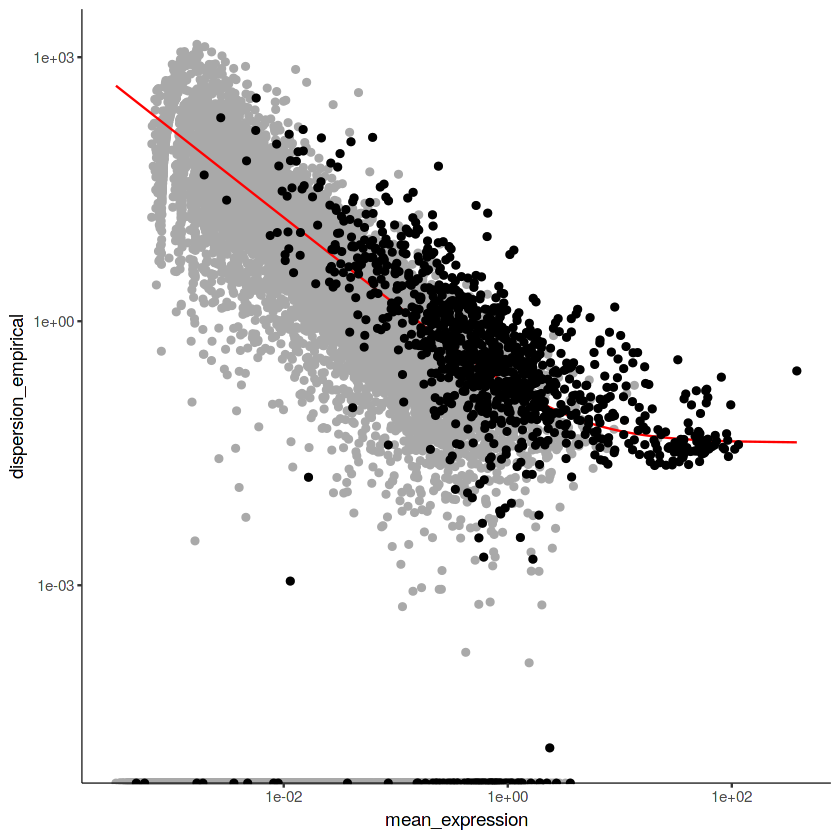

In [34]:
diff.genes <- read.csv( paste0(outputRoot,'../a2/02_subcluster_diff_genes_wilcox.csv'))
diff.genes <- subset(diff.genes,p_val_adj<0.01)$gene
mycds <- setOrderingFilter(mycds, diff.genes)
p1 <- plot_ordering_genes(mycds)
p1

### 使用seurat选择的高变基因

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


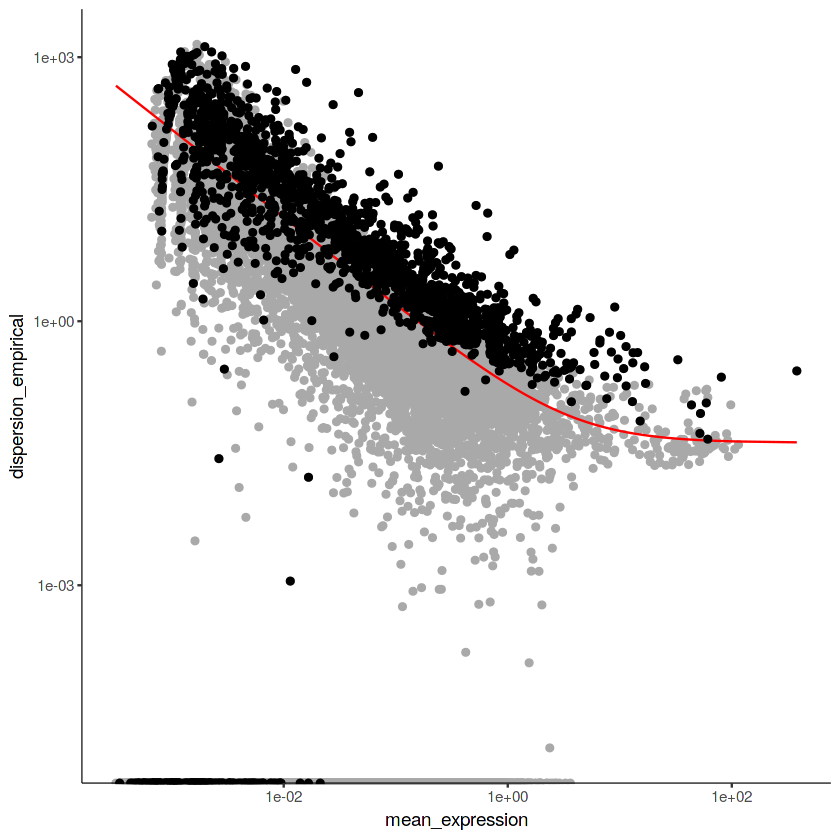

In [35]:
var.genes <- VariableFeatures(scRNAsub)
mycds <- setOrderingFilter(mycds, var.genes)
p2 <- plot_ordering_genes(mycds)
p2

### 使用monocle选择的高变基因

Warning message:
“Transformation introduced infinite values in continuous y-axis”


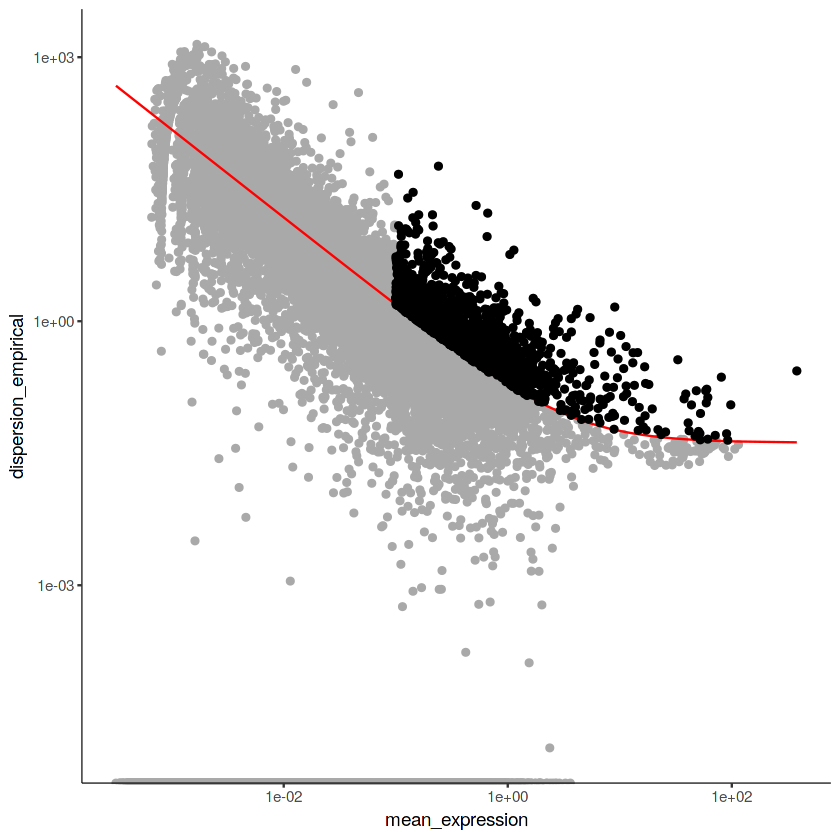

In [36]:
disp_table <- dispersionTable(mycds)
disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id
mycds <- setOrderingFilter(mycds, disp.genes)
p3 <- plot_ordering_genes(mycds)
p3

#### monocle 也可tSNE聚类

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


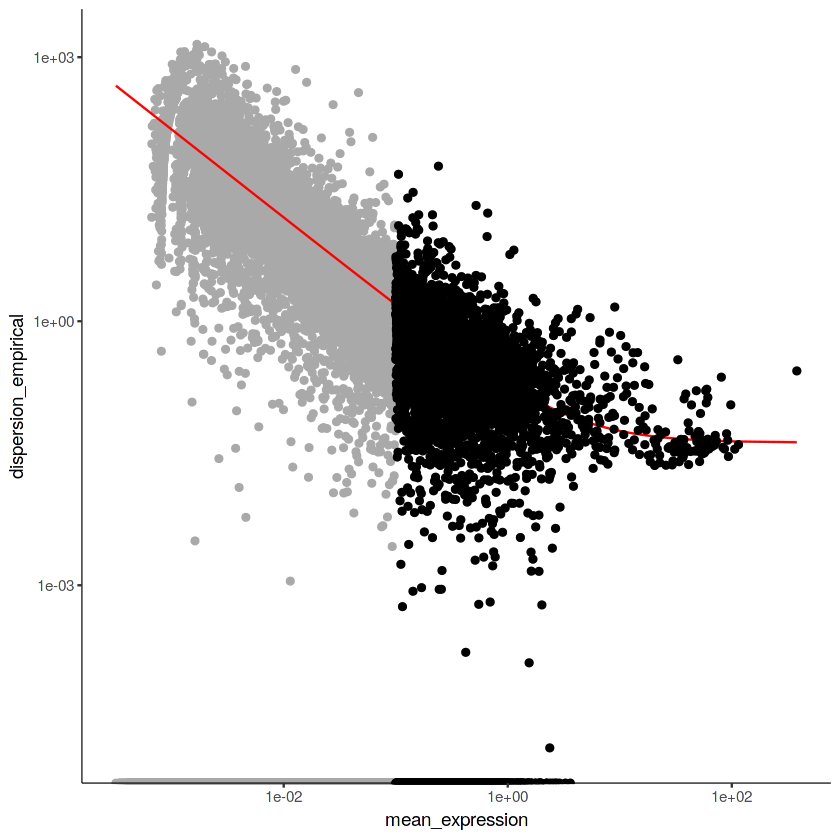

In [116]:
## 另一个实例，筛选条件比较宽

#获取离散度表格；
HSMM=mycds
disp_table <- dispersionTable(HSMM)

#提取平均表达量大于0.1的基因；
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1) #这个标准就比较低

#将参与聚类的“高变”基因导入CDS；
HSMM <- setOrderingFilter(HSMM, unsup_clustering_genes$gene_id)
plot_ordering_genes(HSMM)

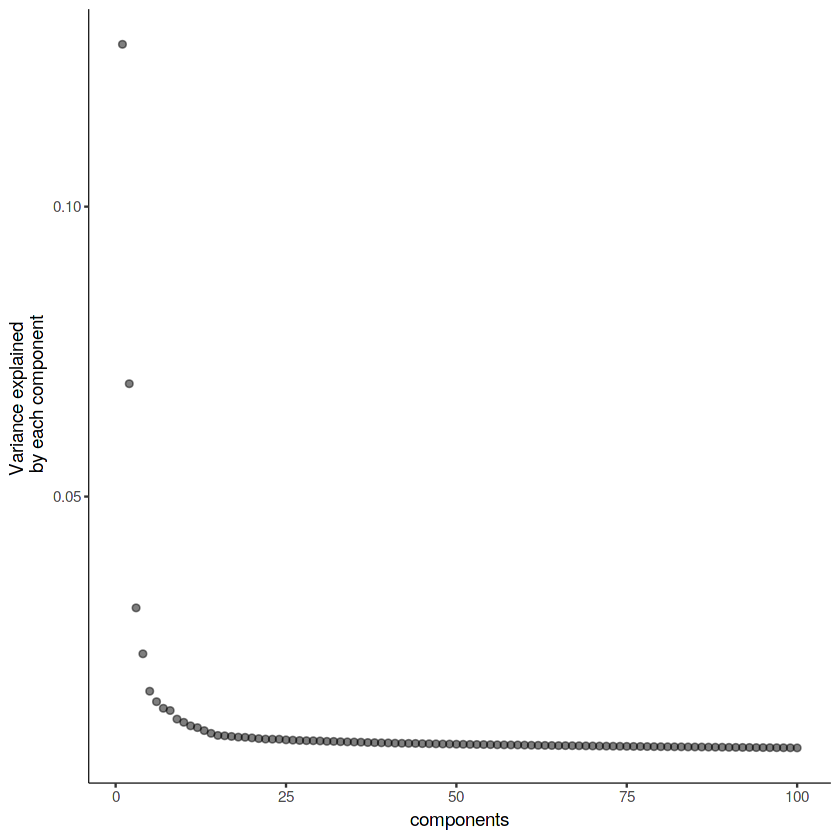

In [118]:
#主成分分析(PCA)与碎石图绘制(运行时间需要3~5min)； 11:12 - 11:17
plot_pc_variance_explained(HSMM, return_all = F)

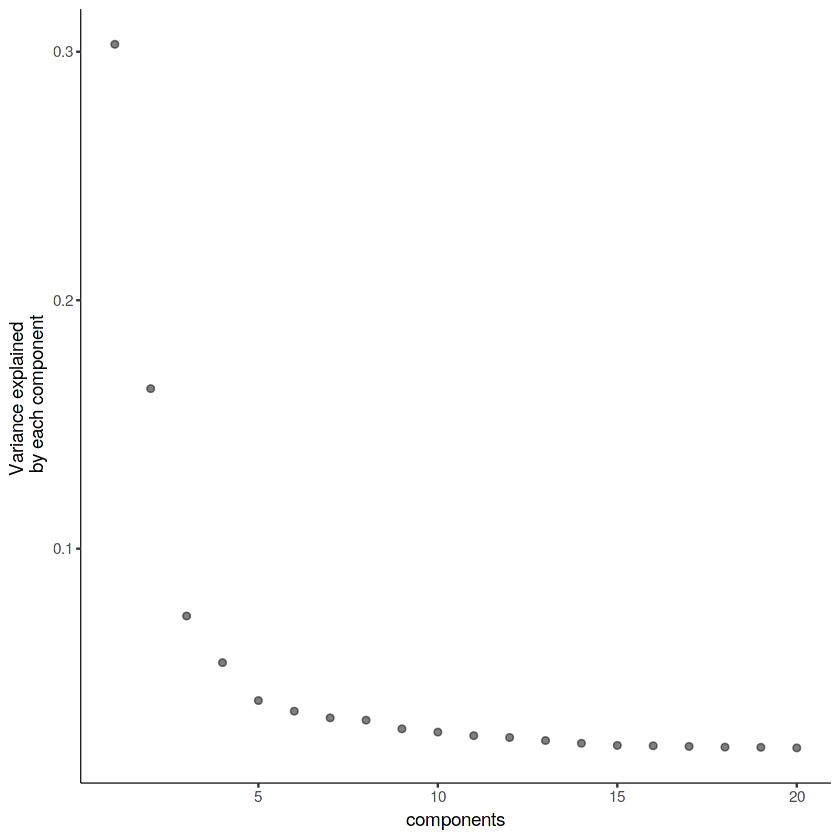

In [119]:
# 为了看清，缩小x的范围
plot_pc_variance_explained(HSMM, return_all = F, max_components = 20) #11:17 - 11:22

Remove noise by PCA ...

Reduce dimension by tSNE ...



Distance cutoff calculated to 3.223199 


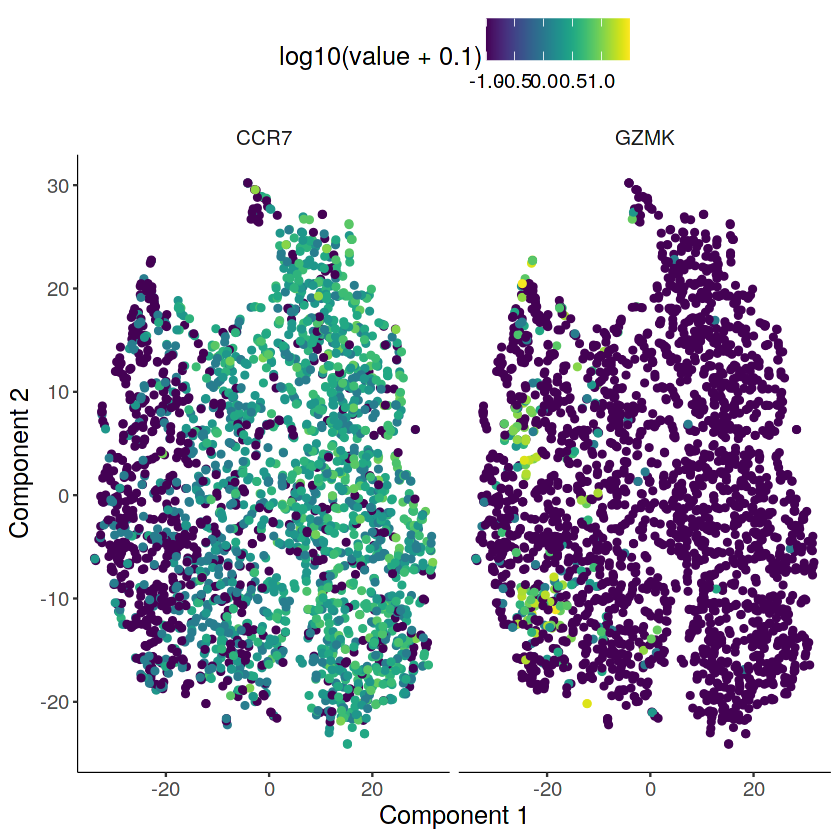

In [125]:
#t-SNE降维；
HSMM <- reduceDimension(HSMM, max_components = 2, num_dim = 10, #6
                        reduction_method = 'tSNE', verbose = T)
#使用densityPeak聚类方法对细胞分群；
HSMM <- clusterCells(HSMM, num_clusters = 20)
#绘制t-SNE分群散点图；
plot_cell_clusters(HSMM, 1, 2, color = "CellType",markers = c("CCR7", "GZMK"))

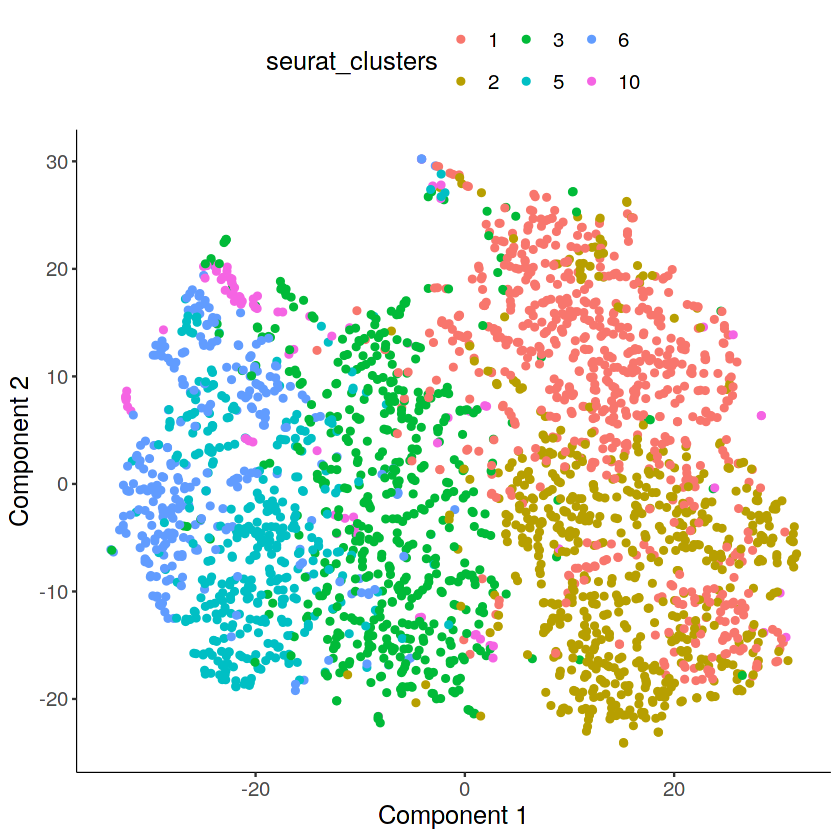

In [126]:
plot_cell_clusters(HSMM, 1, 2, color = "seurat_clusters")

In [131]:
rm(HSMM)

### 结果对比

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


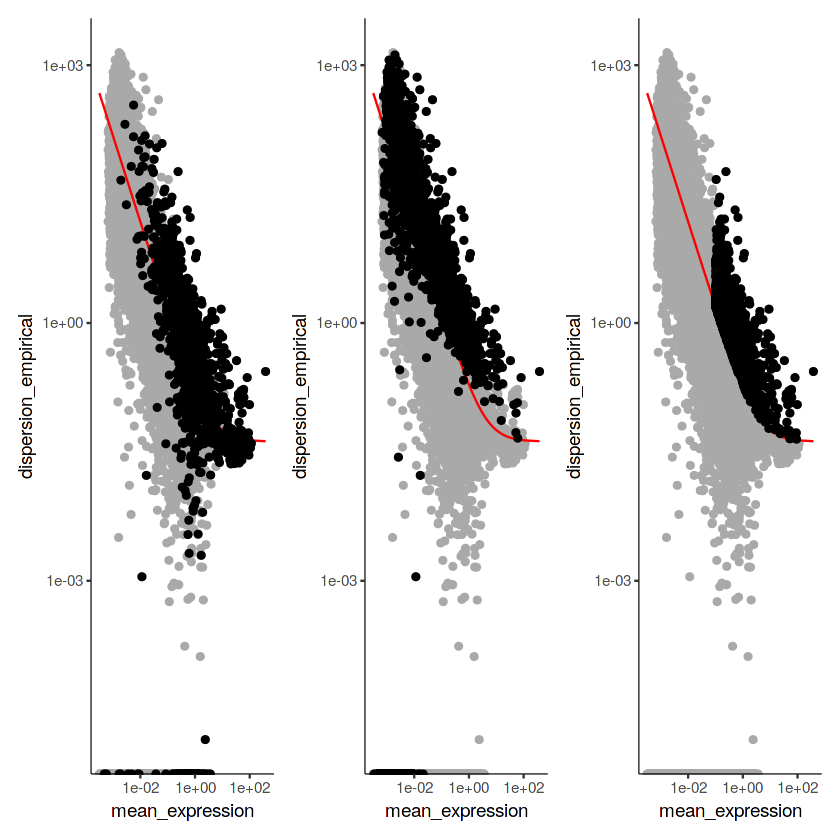

In [37]:
p0=p1|p2|p3
print(p0)

ggsave( paste0(outputRoot, "01_3_select_gene_method.pdf"),plot=p0, width=14, height=6 )

选择不同的基因集，拟时分析的结果不同，实践中可以几种方法都试一下。

# 降维及细胞排序

## 使用monocle选择的高变基因

In [38]:
# 使用disp.genes开展后续分析（monocle选择的高变基因） 9:42 - 9:45
#降维
mycds <- reduceDimension(mycds, max_components = 2, method = 'DDRTree')
#细胞排序
mycds <- orderCells(mycds)
mycds

CellDataSet (storageMode: environment)
assayData: 22860 features, 2592 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACGAACACCGAATT AAACGAACAGACACCC ... TTTGTTGTCCTAGCTC
    (2592 total)
  varLabels: orig.ident nCount_RNA ... State (11 total)
  varMetadata: labelDescription
featureData
  featureNames: AL627309.1 AL627309.3 ... AC007325.4 (22860 total)
  fvarLabels: gene_short_name use_for_ordering
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

### State轨迹分布图

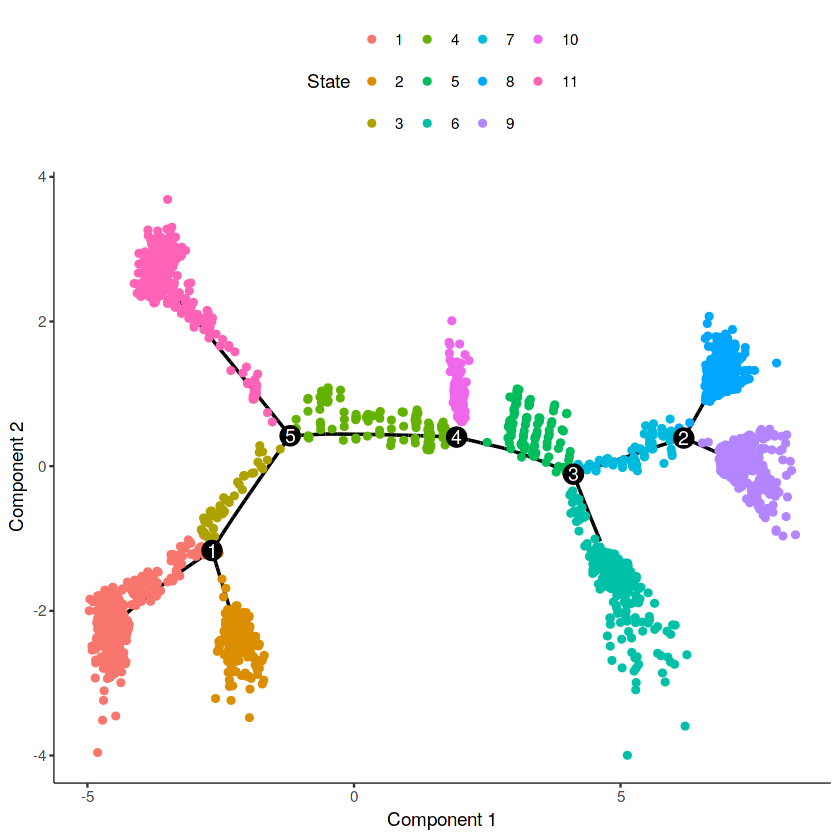

In [44]:
plot1 <- plot_cell_trajectory(mycds, color_by = "State")
print(plot1)
ggsave( paste0(outputRoot, "01_pseudotime1_State.pdf"), plot = plot1, width = 6, height = 5)
#ggsave( paste(outputRoot, "01_pseudotime_State.png"), plot = plot1, width = 6, height = 5)

### Seurat Cluster轨迹分布图

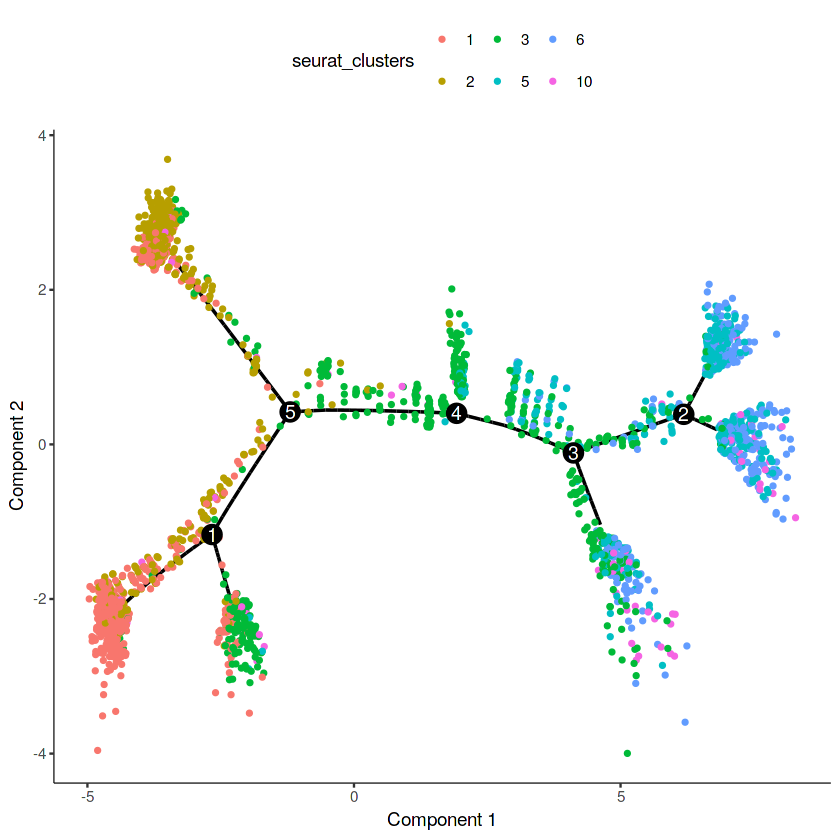

In [45]:
plot2 <- plot_cell_trajectory(mycds, color_by = "seurat_clusters", 
                              cell_size=1)
plot2

ggsave( paste0(outputRoot, "02_pseudotime2_Cluster.pdf"), plot = plot2, width = 6, height = 5)

### Pseudotime轨迹图

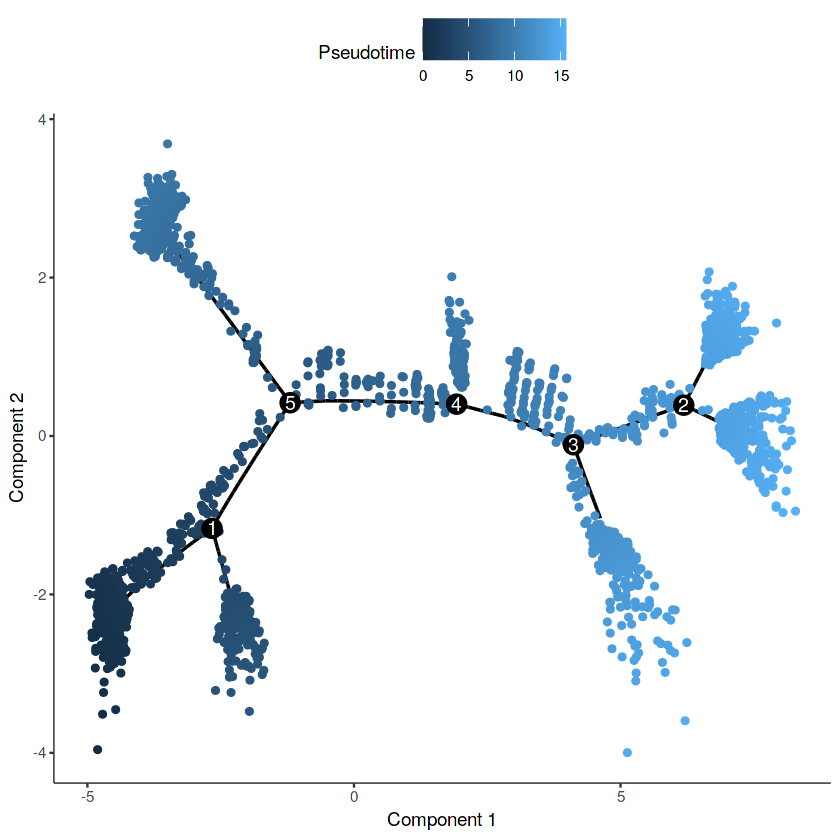

In [46]:
plot3 <- plot_cell_trajectory(mycds, color_by = "Pseudotime")
plot3

ggsave( paste0(outputRoot,"02_pseudotime3_Pseudotime.pdf"), plot = plot3, width = 6, height = 5)

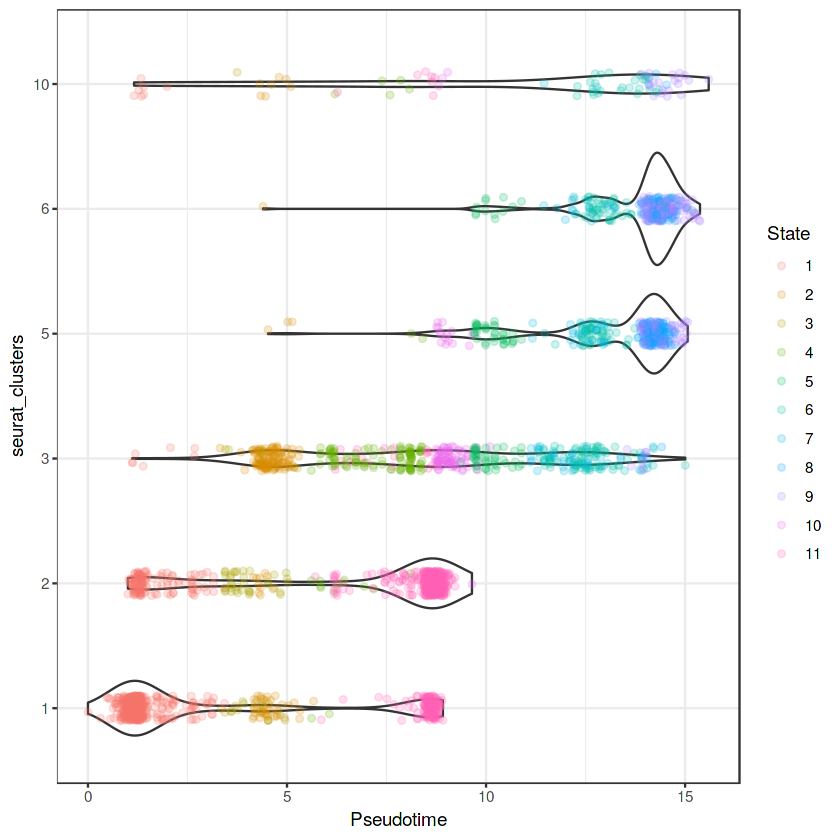

In [115]:
library(ggplot2)

ggplot(pData(mycds), aes(x=Pseudotime, y=seurat_clusters))+
    geom_violin()+
    geom_jitter(width=0, height=0.1, aes(color=State), alpha=0.2)+
    #geom_point()+
    theme_bw()

### 更多属性，color_by=

In [52]:
(function(){
    rs=pData(mycds)
    
    print(dim(rs))
    print(table( rs$cellType )) # 这是之前学习seurat包时分析的结果，可能不准确。
    head(rs)
})()


[1] 2592   11

           ?            B   CD14+ Mono     CD4+ CTL        CD8 T           DC 
           0            0            0            0           42            0 
FCGR3A+ Mono Memory CD4 T  Naive CD4 T           NK     Platelet 
           0         1227         1323            0            0 


orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACGAACACCGAATT pbmc10k    10146      2406         3.617189   1              
AAACGAACAGACACCC pbmc10k     8703      2369         3.171320   3              
AAACGCTAGTATGTAG pbmc10k     5903      1578         2.134508   1              
AAACGCTGTATTGGCT pbmc10k    18850      3628         5.586207   3              
AAACGCTTCGTGGCGT pbmc10k     8595      1974         4.141943   1              
AAAGAACCATTCTCTA pbmc10k     6408      1975         4.697253   3              
                 seurat_clusters cellType     RNA_snn_res.0.9 Size_Factor
AAACGAACACCGAATT 1               Naive CD4 T  1               1.2680418  
AAACGAACAGACACCC 3               Memory CD4 T 3               1.0876964  
AAACGCTAGTATGTAG 1               Naive CD4 T  1               0.7377539  
AAACGCTGTATTGGCT 3               Memory CD4 T 3               2.3558633  
AAACGCTTCGTGGCGT 2               Naive CD4 T  2               1.0741987  
AAAGAACCATTCTCTA 3               Memory CD4 T 3               0.8008685  
                 Pseudotime State
AAACGAACACCGAATT  1.367655  1    
AAACGAACAGACACCC 12.206015  6    
AAACGCTAGTATGTAG  8.595491  11   
AAACGCTGTATTGGCT  4.393371  2    
AAACGCTTCGTGGCGT  8.621804  11   
AAAGAACCATTCTCTA  4.652847  2

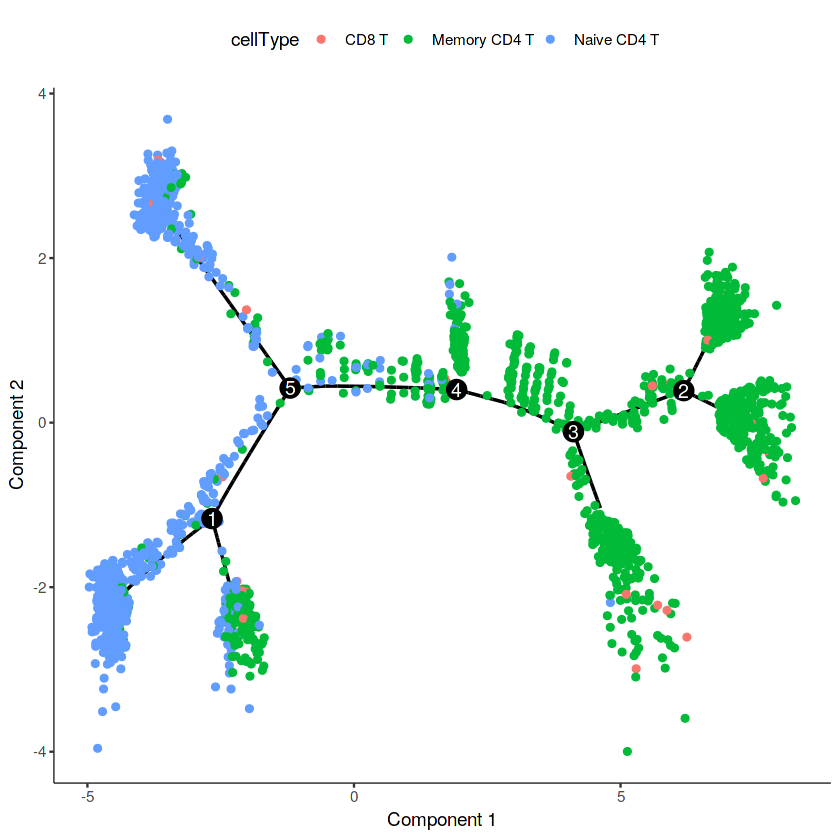

In [53]:
plot_cell_trajectory(mycds, color_by = "cellType")

### 合并作图

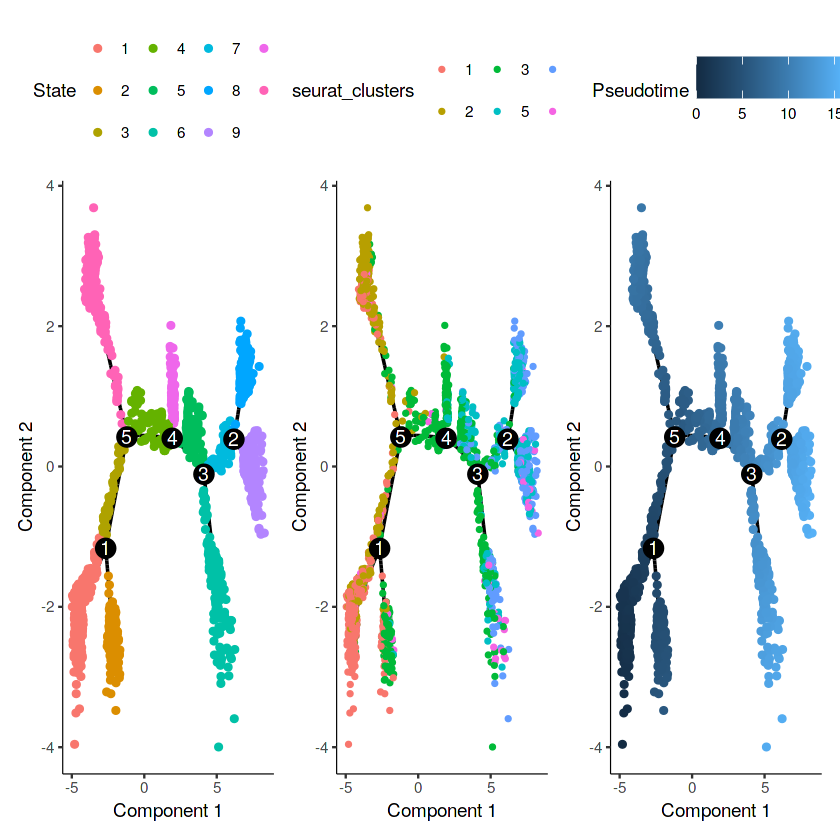

In [48]:
plotc <- plot1|plot2|plot3
plotc

ggsave( paste0(outputRoot,"02_pseudotime4_Combination.pdf"), plot = plotc, width = 10, height = 3.5)

### 轨迹图分面显示

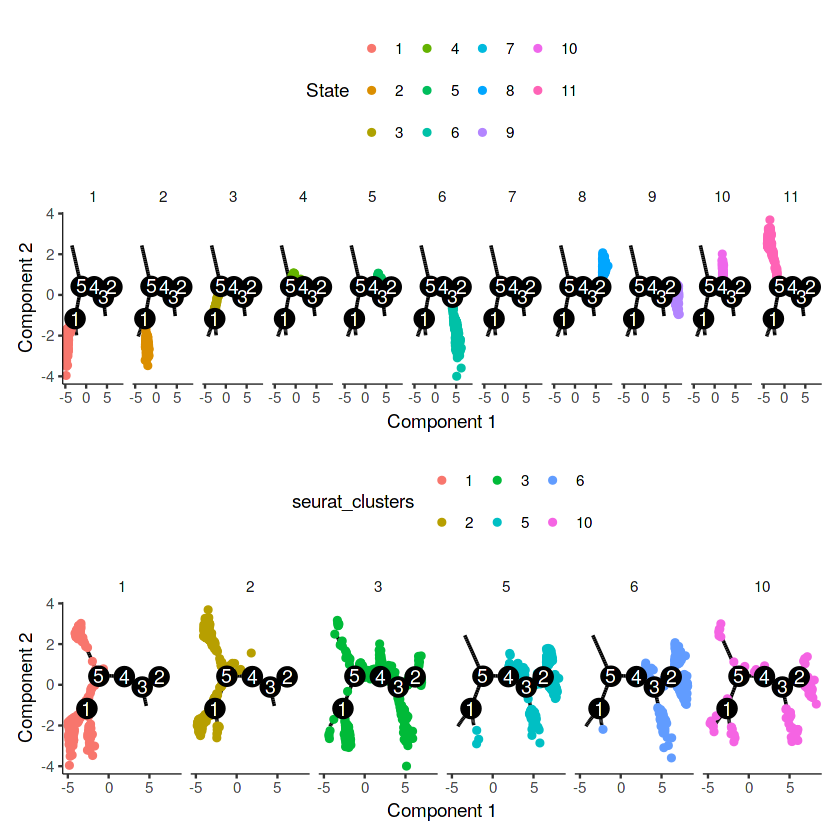

In [55]:
p1 <- plot_cell_trajectory(mycds, color_by = "State") + facet_wrap(~State, nrow = 1)
p2 <- plot_cell_trajectory(mycds, color_by = "seurat_clusters") + facet_wrap(~seurat_clusters, nrow = 1)
plotc <- p1/p2
plotc

ggsave( paste0(outputRoot, "02_pseudotime1_2_trajectory_facet.pdf"), plot = plotc, width = 12, height = 10)

### 保存结果

In [49]:
write.csv(pData(mycds), paste0(outputRoot,"02_pseudotime_pseudotime.csv") )

# Monocle基因可视化

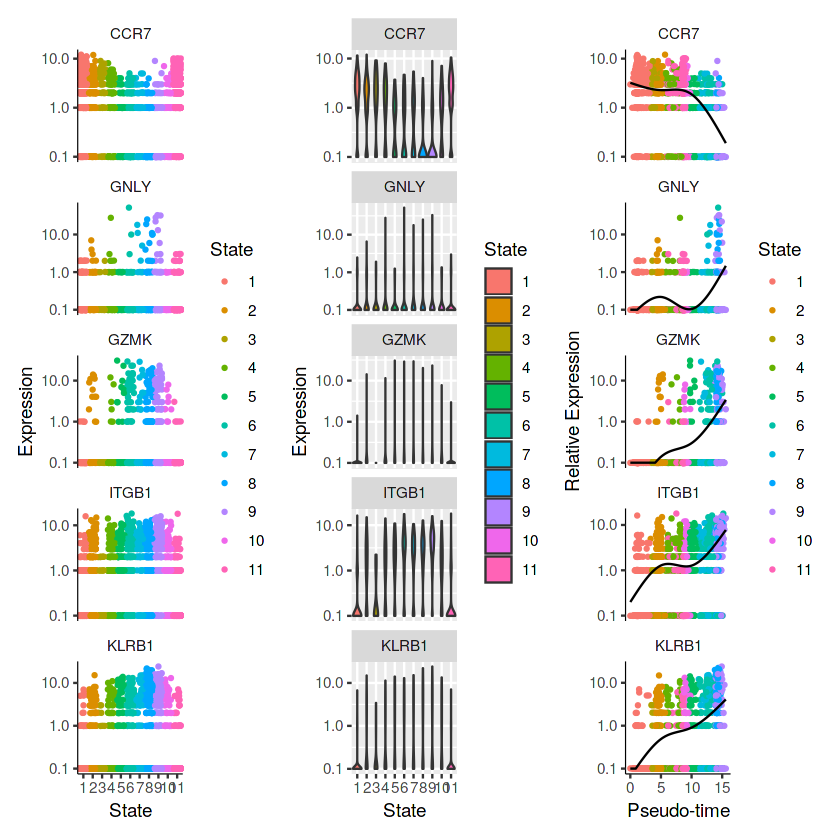

In [57]:
s.genes <- c("ITGB1","CCR7","KLRB1","GNLY", "GZMK")
p1 <- plot_genes_jitter(mycds[s.genes,], grouping = "State", color_by = "State")
p2 <- plot_genes_violin(mycds[s.genes,], grouping = "State", color_by = "State")
p3 <- plot_genes_in_pseudotime(mycds[s.genes,], color_by = "State")
plotc <- p1|p2|p3
plotc

ggsave( paste0(outputRoot,"03_pseudotime_genes_visual.pdf"), plot = plotc, width = 8, height = 5.5)

# 拟时相关基因聚类热图

Monocle中differentialGeneTest()函数可以按条件进行差异分析，将相关参数设为fullModelFormulaStr = "~sm.ns(Pseudotime)"时，可以找到与拟时先关的差异基因。

- 我们可以按一定的条件筛选基因后进行差异分析，全部基因都输入会耗费比较长的时间。
- 建议使用cluster差异基因或高变基因输入函数计算。
- 分析结果主要依据qval区分差异的显著性，筛选之后可以用plot_pseudotime_heatmap函数绘制成热图。

## cluster差异基因

In [59]:
diff.genes <- read.csv('backup/a2/02_subcluster_diff_genes_wilcox.csv')
head(diff.genes)

sig_diff.genes <- subset(diff.genes,  p_val_adj<0.0001 & abs(avg_logFC)>0.75)$gene
sig_diff.genes <- unique(as.character(sig_diff.genes))
length(sig_diff.genes) # gene number

gene      p_val         avg_logFC  pct.1 pct.2 p_val_adj     cluster
1 CD8B       0.000000e+00  1.1834200 0.988 0.222  0.000000e+00 0      
2 LINC02446  0.000000e+00  1.1392607 0.740 0.093  0.000000e+00 0      
3 CD8A      1.369331e-282  0.7194928 0.913 0.238 3.130291e-278 0      
4 KLRK1     3.132073e-228  0.5990178 0.877 0.252 7.159918e-224 0      
5 NELL2     2.304334e-176  0.5188465 0.680 0.216 5.267709e-172 0      
6 ANXA1     2.720581e-159 -1.0151156 0.371 0.735 6.219249e-155 0

[1] 142

In [60]:
# 1min;
diff_test <- differentialGeneTest(mycds[sig_diff.genes, ], cores = 10, 
                              fullModelFormulaStr = "~sm.ns(Pseudotime)")
sig_gene_names <- row.names(subset(diff_test, qval < 0.01))
length(sig_gene_names)

[1] 124

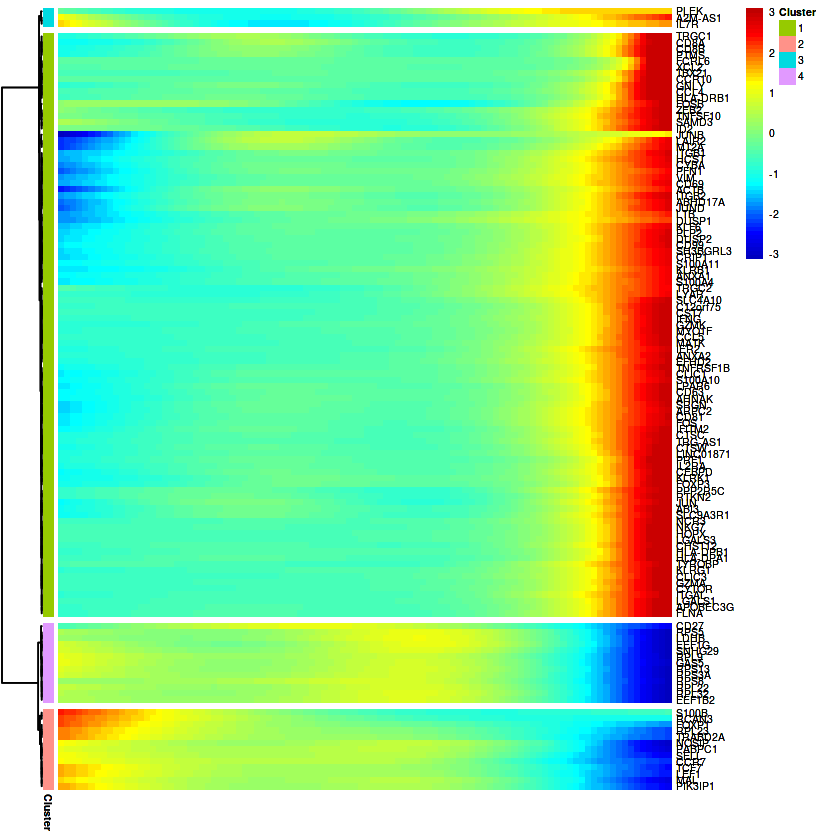

In [68]:
p1 = plot_pseudotime_heatmap(mycds[sig_gene_names,], num_clusters=4, #default=6, try 3-6
                             show_rownames=T, return_heatmap=T)
p1

ggsave( paste0(outputRoot,"04_pseudotime_pseudotime_heatmap1.pdf"), plot = p1, width = 5, height = 10)

## 高变基因

In [69]:
disp_table <- dispersionTable(mycds)
disp.genes <- subset(disp_table, mean_expression >= 0.5 & dispersion_empirical >= 1*dispersion_fit)
disp.genes <- as.character(disp.genes$gene_id)
length(disp.genes)
#
diff_test <- differentialGeneTest(mycds[disp.genes,], cores = 4, 
                              fullModelFormulaStr = "~sm.ns(Pseudotime)")
sig_gene_names <- row.names(subset(diff_test, qval < 1e-04))
length(sig_gene_names)

[1] 609

[1] 424

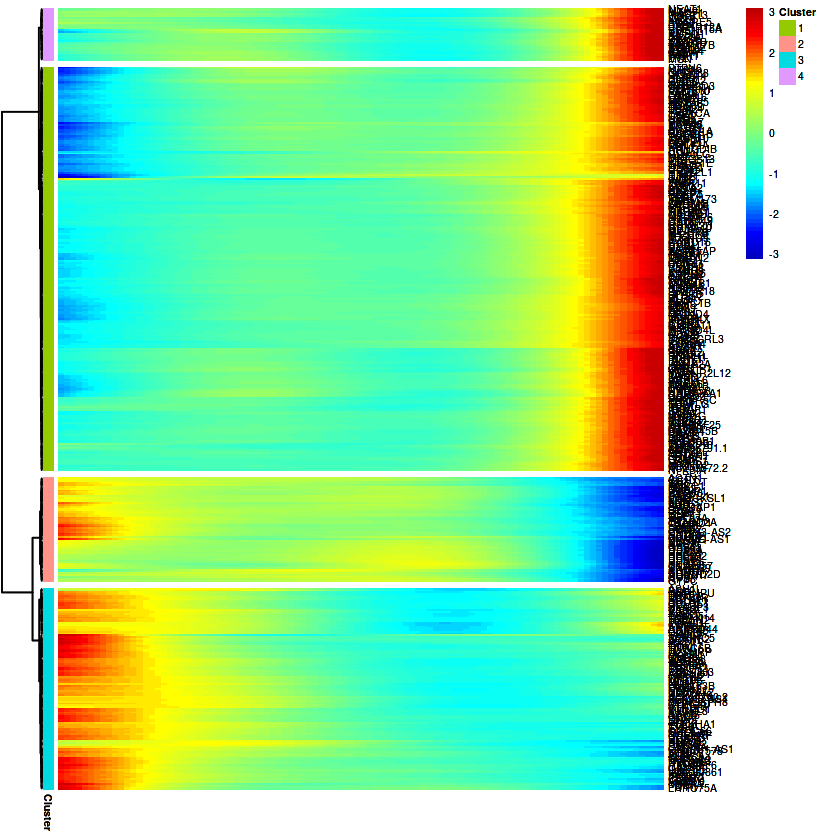

In [72]:
p2 = plot_pseudotime_heatmap(mycds[sig_gene_names,], num_clusters=4,
                             show_rownames=T, return_heatmap=T)
p2

ggsave( paste0(outputRoot,"04_pseudotime_pseudotime_heatmap2.pdf"), plot = p2, width = 5, height = 30)

# BEAM分析

- 单细胞轨迹中通常包括分支，它们的出现是因为细胞的表达模式不同。

- 当细胞做出命运选择时，或者遗传、化学或环境扰动时，就会表现出不同的基因表达模式。

- BEAM(Branched expression analysis modeling)是一种统计方法，用于寻找以依赖于分支的方式调控的基因。

[1] 609

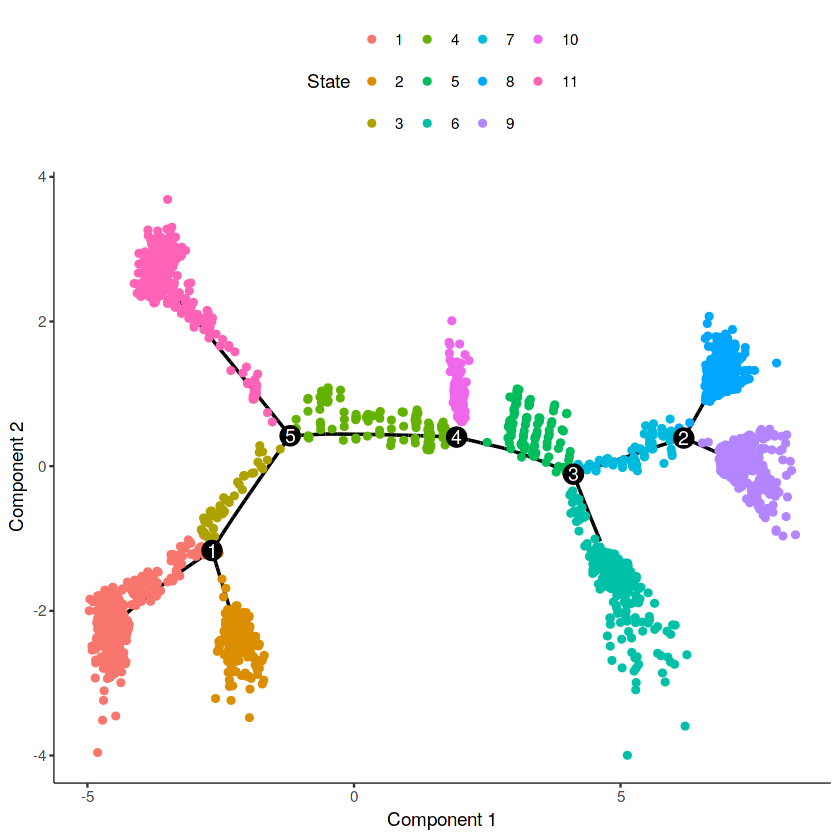

In [82]:
disp_table <- dispersionTable(mycds)
disp.genes <- subset(disp_table, mean_expression >= 0.5 & dispersion_empirical >= 1*dispersion_fit)
disp.genes <- as.character(disp.genes$gene_id)
length(disp.genes)
#
mycds_sub <- mycds[disp.genes,]
plot_cell_trajectory(mycds_sub, color_by = "State")

In [136]:
# BEAM 分析
beam_res <- BEAM(mycds_sub, branch_point = 5, cores = 10)
beam_res <- beam_res[order(beam_res$qval),]
beam_res <- beam_res[,c("gene_short_name", "pval", "qval")]
mycds_sub_beam <- mycds_sub[row.names(subset(beam_res, qval < 1e-4)),]

Warning message in if (progenitor_method == "duplicate") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (progenitor_method == "sequential_split") {:
“the condition has length > 1 and only the first element will be used”


png 
  2

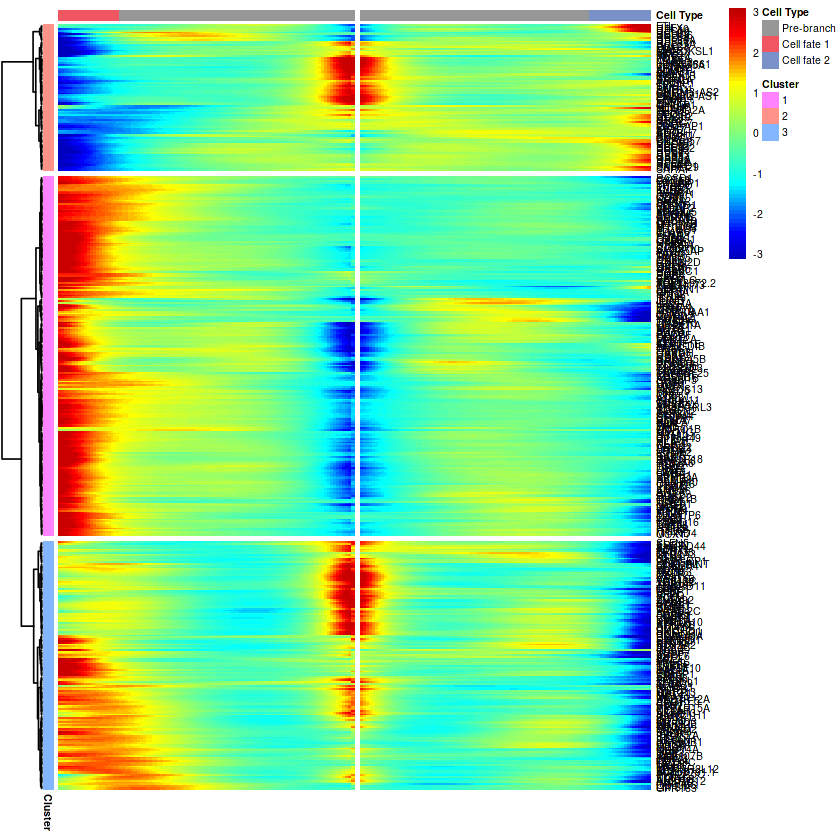

In [140]:
# 画图: 分支点
p3=plot_genes_branched_heatmap(mycds_sub_beam,  branch_point = 5, 
                               num_clusters = 3, show_rownames = T,
                               #branch_labels = c("Cell fate 1", "Cell fate 2"), #没起作用？？在图例中
                              return_heatmap =T)
#print(p3)
pdf( paste0(outputRoot,"05_pseudotime_BEAM.pdf"), width = 5, height = 25)
print(p3$ph_res)
dev.off()

# save

In [128]:
#保存数据，便于之后直接导入使用；
saveRDS(mycds, file = paste0(outputRoot, "pbmc_CD4sub_monocle.final.rds") )